In [2]:
!pip install PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1whQzkW5ih35R1VcSPleVqkHyeb1CgZi1"})   # ID of file you want to access
downloaded.GetContentFile('data.csv')


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from datetime import datetime, date, timedelta


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping 
from keras.layers.normalization import BatchNormalization

import math


import warnings
warnings.filterwarnings("ignore")


In [4]:
df = pd.read_csv('data.csv')

In [5]:
df.head()

,Datetime,feed_flow,product_flow,feed_concentration,product_concentration,feed_temperature,stage_1_feed_pressure,product_pressure,stage_2_feed_pressure,stage_3_feed_pressure,reject_pressure,A,B,k1,k2,k3,salt_loading,recovery,salt_loading_since_replace,salt_loading_since_clean,running_time_since_clean,running_time_since_replace,feed_ph,feed_turbidity
0,2019-06-01 00:01:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,467.366667,3935.409545,7.890750,NaN
1,2019-06-01 00:02:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,467.383333,3935.426212,7.947625,NaN
2,2019-06-01 00:03:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,467.400000,3935.442878,7.890750,NaN
3,2019-06-01 00:04:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,467.416667,3935.459545,7.914375,NaN
4,2019-06-01 00:05:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,467.433333,3935.476212,7.914375,NaN


In [6]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.sort_values(by ='Datetime' )
df.index = df['Datetime']

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 527039 entries, 2019-06-01 00:01:00+00:00 to 2020-05-31 23:59:00+00:00
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   Datetime                    527039 non-null  datetime64[ns, UTC]
 1   feed_flow                   152075 non-null  float64            
 2   product_flow                152075 non-null  float64            
 3   feed_concentration          152075 non-null  float64            
 4   product_concentration       152075 non-null  float64            
 5   feed_temperature            152075 non-null  float64            
 6   stage_1_feed_pressure       152075 non-null  float64            
 7   product_pressure            152075 non-null  float64            
 8   stage_2_feed_pressure       152075 non-null  float64            
 9   stage_3_feed_pressure       152075 non-null  float64            
 10

#### Notice that we have done any data cleaning since this is a time-series data. The data samples have temporal dependency between each other and hence, the ordering/sequence of data points has to be maintained. Hence, we cannot delete or discard the rows which has Null values or are empty.

In [6]:
# Time-series Forecasting models and Regression models works best when the number of missings values for the features are less. 
# But almost all the features have 71% of its data missing based on the tables above.

# Hence extracting data between a date range which has few missing values.

df2 = df.loc['2020-02-15 00:00:00' : '2020-04-07 00:00:00']

# The data has few missing values only in between the date range of Feb 15th 2021 - April 7th 2021 as shown in the table below

subset = df2[['feed_flow', 'feed_concentration', 'feed_temperature', 'salt_loading', 'recovery', 'feed_ph', 'feed_turbidity', 'stage_1_feed_pressure','A']]



In [7]:
#Imputing missing values with '0'

subset['feed_flow'] = subset['feed_flow'].fillna(0)
subset['feed_concentration'] = subset['feed_concentration'].fillna(0)
subset['feed_temperature'] = subset['feed_temperature'].fillna(0)
subset['salt_loading'] = subset['salt_loading'].fillna(0)
subset['recovery'] = subset['recovery'].fillna(0)
subset['feed_ph'] = subset['feed_ph'].fillna(0)
subset['feed_turbidity'] = subset['feed_turbidity'].fillna(0)
subset['A'] = subset['A'].fillna(0)
subset['stage_1_feed_pressure'] = subset['stage_1_feed_pressure'].fillna(0)
subset['recovery'] = subset['recovery'].fillna(0)

In [8]:
subset.reset_index(drop=True)


,feed_flow,feed_concentration,feed_temperature,salt_loading,recovery,feed_ph,feed_turbidity,stage_1_feed_pressure,A
0,0.000000,0.000,0.000000,0.000000,0.000000,7.898625,0.000000,0.00000,0.000000
1,0.000000,0.000,0.000000,0.000000,0.000000,7.881125,0.000000,0.00000,0.000000
2,0.000000,0.000,0.000000,0.000000,0.000000,7.879375,0.000000,0.00000,0.000000
3,0.000000,0.000,0.000000,0.000000,0.000000,7.879375,0.000000,0.00000,0.000000
4,0.000000,0.000,0.000000,0.000000,0.000000,7.863625,0.000000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...
74876,156.616128,225.720,16.631944,0.035351,0.806466,7.893375,0.000000,11.52930,0.003856
74877,156.616128,226.440,16.586806,0.035464,0.806466,7.877625,0.000000,11.56292,0.003849
74878,158.193432,227.115,16.586806,0.035928,0.802806,7.877625,0.000000,11.63014,0.003838
74879,157.557132,227.430,16.572917,0.035833,0.802010,7.877625,0.014687,11.63014,0.003819


### Building time-series forecasting Multi-step LSTM model for univariate data using the - Stage_1_feed_pressure' feature and Date range: 15th Feb - 7th April

In [9]:

np.random.seed(1)

df_stg = subset[['stage_1_feed_pressure']]
    
#Normalize the 'stage_1_feed_pressure' feature using Minmax Normalization
minmax_scale = MinMaxScaler().fit(df_stg[['stage_1_feed_pressure']])
df_stg['minmax_stage_fpressure'] = minmax_scale.transform(df_stg[['stage_1_feed_pressure']])
    
#Dataframe column into series of values
entire_dataset = df_stg['minmax_stage_fpressure'].values

print("**********************************")
#Previous 15mins (look_back) timesteps used to predict next 15mins. 
look_back = 15
pred_length = 15
dataset_len = len(entire_dataset)

#split the dataset into train & text in the ratio of 70:30
train_size = int(dataset_len * 0.70)
test_size = dataset_len - train_size


#Change the shape of the series from 1D array to 2D array
entire_dataset = entire_dataset.reshape(-1,1)

train, test = entire_dataset[0:train_size,:], entire_dataset[train_size:dataset_len,:]

#Covert into supervised problem. Input -> Output using Sequence of previous 
#time steps to generate future time steps
# Eg. T1, T2, T3 -> T4
#     T2, T3, T4 -> T5
def create_subSeq(dataseries, look_back, pred_length):
    ip, op = [], []
    for i in range(len(dataseries)):
        ip_index = i + look_back
        op_index = ip_index + pred_length
        if(op_index > len(dataseries)):
            break
        seq_x, seq_y = dataseries[i:ip_index], dataseries[ip_index:op_index]
        ip.append(seq_x)
        op.append(seq_y)
    return np.array(ip), np.array(op)


X_train, Y_train = create_subSeq(train, look_back, pred_length)
X_test, Y_test = create_subSeq(test, look_back, pred_length)

Y_test_list = Y_test

# reshape from [samples, timesteps] into [samples, timesteps, features]-> 3D array as input to LSTM
# sample = number of samples, timesteps= look_back, features = 1 
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

#reshape Y's as [samples, timesteps]-> samples, pred_length
Y_train = Y_train.reshape((Y_train.shape[0], Y_train.shape[1]))
Y_test = Y_test.reshape((Y_test.shape[0], Y_test.shape[1]))

print("Xtrain reshaped",X_train.shape)

print("Ytrain reshaped",Y_train.shape)

print("Ytest reshaped",Y_test.shape)

print("Xtest reshaped",X_test.shape)





**********************************
Xtrain reshaped (52387, 15, 1)
Ytrain reshaped (52387, 15)
Ytest reshaped (22436, 15)
Xtest reshaped (22436, 15, 1)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 512)           1052672   
_________________________________________________________________
dropout (Dropout)            (None, 15, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 256)           787456    
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 15, 128)           197120    
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 15, 64)            4

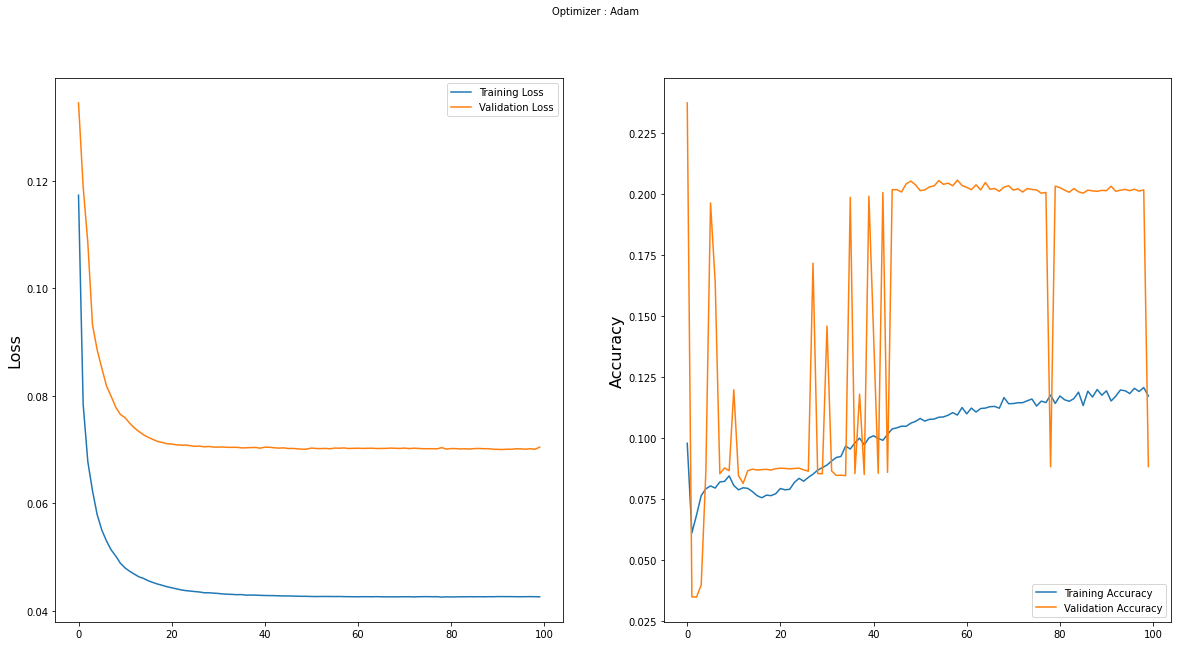

In [10]:
#Build model
model = Sequential()
model.add(LSTM(512,activation ='tanh', input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(256,activation ='tanh', return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(128,activation ='tanh', return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(64,activation ='tanh', return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dense(pred_length))

adam = keras.optimizers.Adam(lr=0.0001)

model.compile(loss='mean_squared_error',optimizer=adam,metrics=['accuracy'])
model.summary()

history = model.fit(X_train, Y_train, epochs=100, batch_size=256, validation_split=0.2,verbose=2,shuffle=False)



plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()





In [11]:

#Prediction of Y_train and Y_test
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)


ytrainlist = []
ytrainpredlist = []
ytestpredlist = []
ytestlist = []
l=0

#Plotting the actual time-series, trained, tested values for which we are accordingly storing the values in a list based on the number of look_back, future_steps that were used to created sequential series

print("Y_test",Y_test.shape)
print("testPredict",testPredict.shape)

for i in range(testPredict.shape[0]-1):
  ytestpredlist.append(testPredict[i][0])
  ytestlist.append(Y_test[i][0])
  l=i

for i in range(trainPredict.shape[0]-1):
  ytrainlist.append(Y_train[i][0])
  ytrainpredlist.append(trainPredict[i][0])

print("before last index:",l)
print("Y_test",Y_test.shape)
print("testPredict",testPredict.shape)

last_row_index = testPredict.shape[0]-1
print("last row index",last_row_index-1)
for i in range(testPredict.shape[1]):
  ytestpredlist.append(testPredict[last_row_index][i])
  ytestlist.append(Y_test[last_row_index][i])

for i in range(trainPredict.shape[1]):
  ytestpredlist.append(trainPredict[last_row_index][i])
  ytestlist.append(Y_train[last_row_index][i])

print("ytestpredlist",len(ytestpredlist))
print("Y_test",Y_test.shape)
print("testPredict",testPredict.shape)

Y_test = np.array(ytestlist)
Y_test = Y_test.reshape((-1,1))


testPred = np.array(ytestpredlist)
testPred = testPred.reshape((-1,1))

Y_train = np.array(ytrainlist)
Y_train = Y_train.reshape((-1,1))

trainPred = np.array(ytrainpredlist)
trainPred = trainPred.reshape((-1,1))


trainPred = minmax_scale.inverse_transform(trainPred)
trainY = minmax_scale.inverse_transform(Y_train)
testPred = minmax_scale.inverse_transform(testPred)
testY = minmax_scale.inverse_transform(Y_test)

print(trainY.shape, testY.shape)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPred))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPred))
print('Test Score: %.2f RMSE' % (testScore))

Y_test (22436, 15)
testPredict (22436, 15)
before last index: 22434
Y_test (22436, 15)
testPredict (22436, 15)
last row index 22434
ytestpredlist 22465
Y_test (22436, 15)
testPredict (22436, 15)
(52386, 1) (22465, 1)
Train Score: 1.33 RMSE
Test Score: 1.66 RMSE


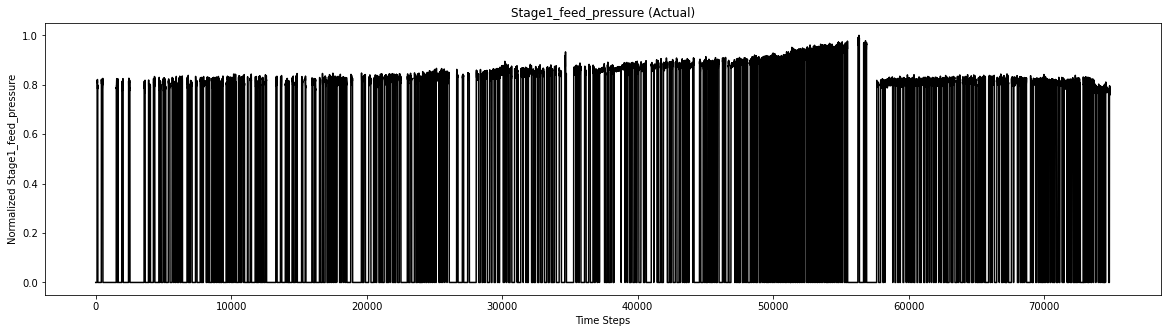

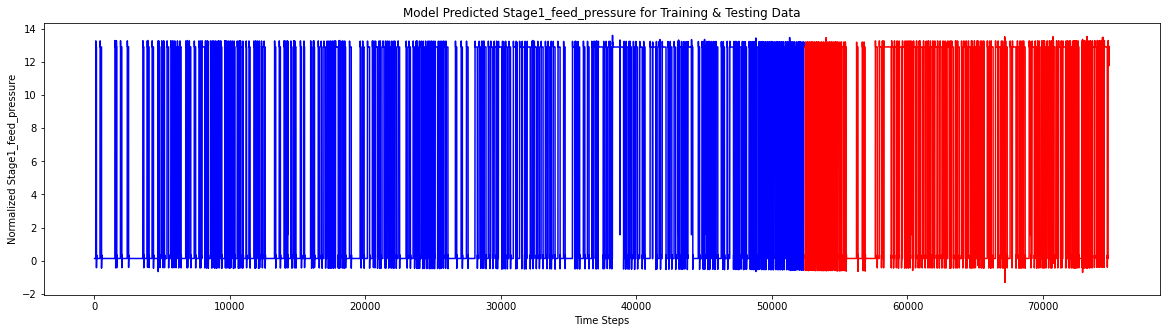

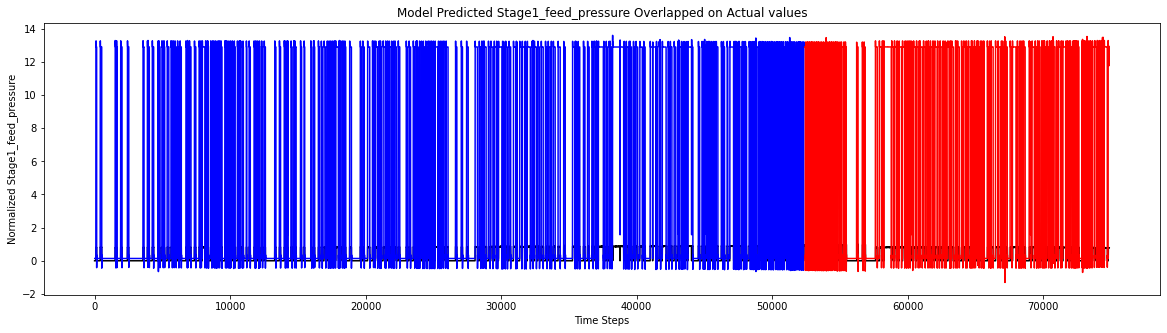

In [12]:

#Compare actual Ytrain, Ytest with predicted Ytrain & Ytest
# %matplotlib inline


#Plot the Forecasted values overlapped on top of Actual values of Stage1_feed_pressure data(normalized)
trainPredictPlot = np.empty_like(entire_dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPred)+look_back, :] = trainPred

testPredictPlot = np.empty_like(entire_dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPred)+(look_back)*2:len(entire_dataset), :] = testPred

plt.figure(figsize=(20,5))
plt.plot(entire_dataset, color = 'black',label = 'Stage1_feed_pressure (Actual)')
plt.title('Stage1_feed_pressure (Actual)')
plt.ylabel('Normalized Stage1_feed_pressure')
plt.xlabel('Time Steps')
plt.show(block = False)

plt.figure(figsize=(20,5))
plt.plot(trainPredictPlot, color = 'blue', label = 'Stage1_feed_pressure (Trained)')
plt.plot(testPredictPlot, color = 'red', label = 'Stage1_feed_pressure (Tested)')
plt.title('Model Predicted Stage1_feed_pressure for Training & Testing Data')
plt.ylabel('Normalized Stage1_feed_pressure')
plt.xlabel('Time Steps')
plt.show(block = False)

plt.figure(figsize=(20,5))
plt.plot(entire_dataset, color = 'black')
plt.plot(trainPredictPlot, color = 'blue')
plt.plot(testPredictPlot, color = 'red', label = 'Stage1_feed_pressure(Predicted)')
plt.title('Model Predicted Stage1_feed_pressure Overlapped on Actual values')
plt.ylabel('Normalized Stage1_feed_pressure')
plt.xlabel('Time Steps')
plt.show(block = False)



  

#Imputing the missing value with mean values and then building a multistep LSTM model for stage_1_feed_pressure

**********************************
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 15, 512)           1052672   
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 512)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 15, 256)           787456    
_________________________________________________________________
dropout_5 (Dropout)          (None, 15, 256)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 15, 128)           197120    
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 128)           0         
_________________________________________________________________
lstm_8 (LSTM)      

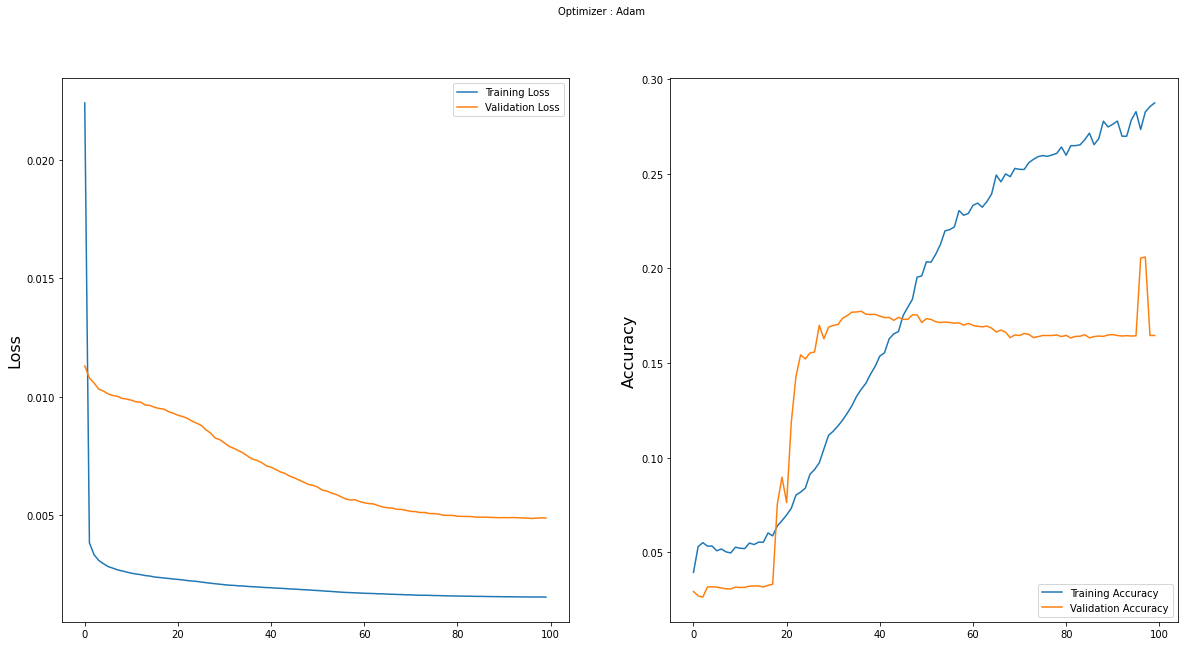

In [13]:
df2 = df.loc['2020-02-15 00:00:00' : '2020-04-07 00:00:00']

subset = df2[['feed_flow', 'feed_concentration', 'feed_temperature', 'stage_1_feed_pressure','A']]

#Imputing missing values with mean vaues of features

subset['feed_flow'] = subset['feed_flow'].fillna(subset['feed_flow'].mean())
subset['feed_concentration'] = subset['feed_concentration'].fillna(subset['feed_concentration'].mean())
subset['feed_temperature'] = subset['feed_temperature'].fillna(subset['feed_temperature'].mean())
subset['A'] = subset['A'].fillna(subset['A'].mean())
subset['stage_1_feed_pressure'] = subset['stage_1_feed_pressure'].fillna(subset['stage_1_feed_pressure'].mean())

subset.reset_index(drop=True)


np.random.seed(1)

df_stg = subset[['stage_1_feed_pressure']]
    
#Normalize the 'stage_1_feed_pressure' feature using Minmax Normalization
minmax_scale = MinMaxScaler().fit(df_stg[['stage_1_feed_pressure']])
df_stg['minmax_stage_fpressure'] = minmax_scale.transform(df_stg[['stage_1_feed_pressure']])
    
#Dataframe column into series of values
entire_dataset = df_stg['minmax_stage_fpressure'].values

print("**********************************")
#Previous 15mins (look_back) timesteps used to predict next 15mins. 
look_back = 15
pred_length = 15
dataset_len = len(entire_dataset)

#split the dataset into train & text in the ratio of 70:30
train_size = int(dataset_len * 0.70)
test_size = dataset_len - train_size


#Change the shape of the series from 1D array to 2D array
entire_dataset = entire_dataset.reshape(-1,1)

train, test = entire_dataset[0:train_size,:], entire_dataset[train_size:dataset_len,:]

#Covert into supervised problem. Input -> Output using Sequence of previous 
#time steps to generate future time steps
# Eg. T1, T2, T3 -> T4
#     T2, T3, T4 -> T5
def create_subSeq(dataseries, look_back, pred_length):
    ip, op = [], []
    for i in range(len(dataseries)):
        ip_index = i + look_back
        op_index = ip_index + pred_length
        if(op_index > len(dataseries)):
            break
        seq_x, seq_y = dataseries[i:ip_index], dataseries[ip_index:op_index]
        ip.append(seq_x)
        op.append(seq_y)
    return np.array(ip), np.array(op)


X_train, Y_train = create_subSeq(train, look_back, pred_length)
X_test, Y_test = create_subSeq(test, look_back, pred_length)

Y_test_list = Y_test

# reshape from [samples, timesteps] into [samples, timesteps, features]-> 3D array as input to LSTM
# sample = number of samples, timesteps= look_back, features = 1 
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

#reshape Y's as [samples, timesteps]-> samples, pred_length
Y_train = Y_train.reshape((Y_train.shape[0], Y_train.shape[1]))
Y_test = Y_test.reshape((Y_test.shape[0], Y_test.shape[1]))

#Build model
model = Sequential()
model.add(LSTM(512,activation ='tanh', input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(256,activation ='tanh', return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(128,activation ='tanh', return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(64,activation ='tanh', return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dense(pred_length))

adam = keras.optimizers.Adam(lr=0.0001)

model.compile(loss='mean_squared_error',optimizer=adam,metrics=['accuracy'])
model.summary()

history = model.fit(X_train, Y_train, epochs=100, batch_size=256, validation_split=0.2,verbose=2,shuffle=False)



plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


last row index 22434
Train Score: 0.09 RMSE
Test Score: 0.15 RMSE


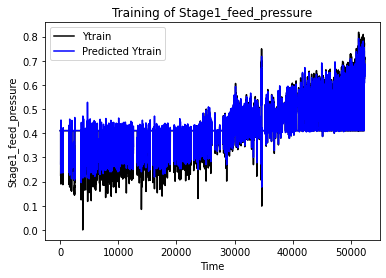

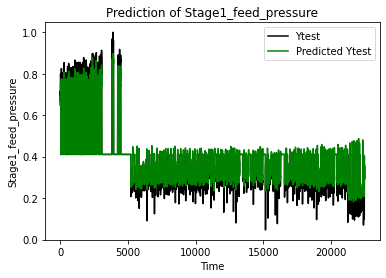

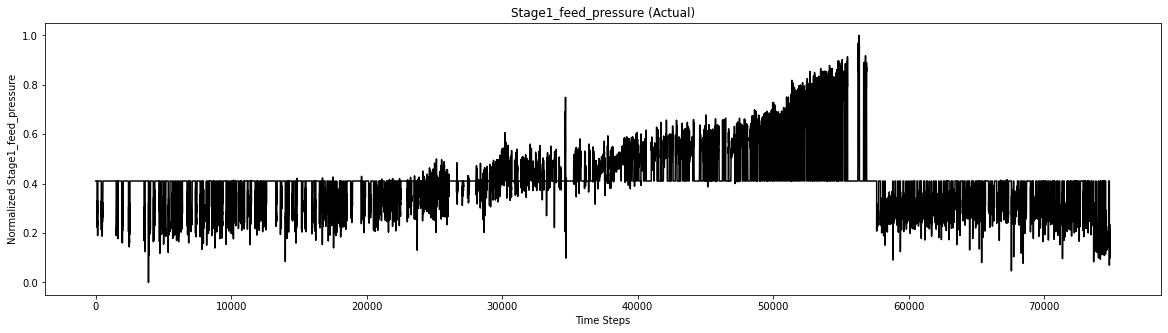

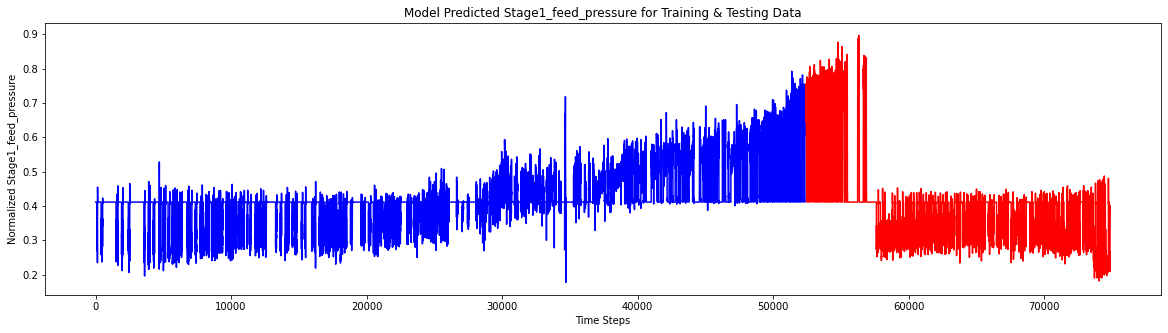

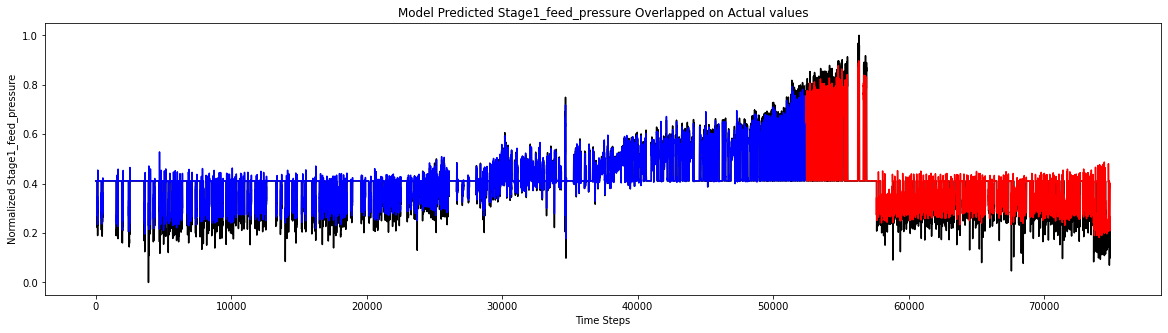

In [14]:

#Prediction of Y_train and Y_test
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

ytrainlist = []
ytrainpredlist = []
ytestpredlist = []
ytestlist = []
l=0

#Plotting the actual time-series, trained, tested values for which we are accordingly storing the values in a list based on the number of look_back, future_steps that were used to created sequential series

for i in range(testPredict.shape[0]-1):
  ytestpredlist.append(testPredict[i][0])
  ytestlist.append(Y_test[i][0])
  l=i

for i in range(trainPredict.shape[0]-1):
  ytrainlist.append(Y_train[i][0])
  ytrainpredlist.append(trainPredict[i][0])


last_row_index = testPredict.shape[0]-1
print("last row index",last_row_index-1)
for i in range(testPredict.shape[1]):
  ytestpredlist.append(testPredict[last_row_index][i])
  ytestlist.append(Y_test[last_row_index][i])

for i in range(trainPredict.shape[1]):
  ytestpredlist.append(trainPredict[last_row_index][i])
  ytestlist.append(Y_train[last_row_index][i])

Y_test = np.array(ytestlist)
Y_test = Y_test.reshape((-1,1))


testPred = np.array(ytestpredlist)
testPred = testPred.reshape((-1,1))

Y_train = np.array(ytrainlist)
Y_train = Y_train.reshape((-1,1))

trainPred = np.array(ytrainpredlist)
trainPred = trainPred.reshape((-1,1))

trainPred_inv = minmax_scale.inverse_transform(trainPred)
trainY_inv = minmax_scale.inverse_transform(Y_train)
testPred_inv = minmax_scale.inverse_transform(testPred)
testY_inv = minmax_scale.inverse_transform(Y_test)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_inv, trainPred_inv))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_inv, testPred_inv))
print('Test Score: %.2f RMSE' % (testScore))

#Compare actual Ytrain, Ytest with predicted Ytrain & Ytest
# %matplotlib inline

plt.plot(Y_train, color = 'black', label = 'Ytrain')
plt.plot(trainPred, color = 'blue', label = 'Predicted Ytrain')
plt.title('Training of Stage1_feed_pressure')
plt.xlabel('Time')
plt.ylabel('Stage1_feed_pressure')
plt.legend()
plt.show(block = False)


plt.plot(Y_test, color = 'black', label = 'Ytest')
plt.plot(testPred, color = 'green', label = 'Predicted Ytest')
plt.title('Prediction of Stage1_feed_pressure')
plt.xlabel('Time')
plt.ylabel('Stage1_feed_pressure')
plt.legend()
plt.show(block = False)

#Plot the Forecasted values overlapped on top of Actual values of Stage1_feed_pressure data(normalized)
trainPredictPlot = np.empty_like(entire_dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPred)+look_back, :] = trainPred

testPredictPlot = np.empty_like(entire_dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPred)+(look_back)*2:len(entire_dataset), :] = testPred

plt.figure(figsize=(20,5))
plt.plot(entire_dataset, color = 'black',label = 'Stage1_feed_pressure (Actual)')
plt.title('Stage1_feed_pressure (Actual)')
plt.ylabel('Normalized Stage1_feed_pressure')
plt.xlabel('Time Steps')
plt.show(block = False)

plt.figure(figsize=(20,5))
plt.plot(trainPredictPlot, color = 'blue', label = 'Stage1_feed_pressure (Trained)')
plt.plot(testPredictPlot, color = 'red', label = 'Stage1_feed_pressure (Tested)')
plt.title('Model Predicted Stage1_feed_pressure for Training & Testing Data')
plt.ylabel('Normalized Stage1_feed_pressure')
plt.xlabel('Time Steps')
plt.show(block = False)

plt.figure(figsize=(20,5))
plt.plot(entire_dataset, color = 'black')
plt.plot(trainPredictPlot, color = 'blue')
plt.plot(testPredictPlot, color = 'red', label = 'Stage1_feed_pressure(Predicted)')
plt.title('Model Predicted Stage1_feed_pressure Overlapped on Actual values')
plt.ylabel('Normalized Stage1_feed_pressure')
plt.xlabel('Time Steps')
plt.show(block = False)



###Based on the above plots, the forecasting looks much better than the previous one (where we imputed missing values with '0') and similar to the actual values (black). 
### Blue indicates the training data, Red indicates the testing data and black indicates the actual values.

###Imputation with mean values is better than '0'. Hence, we will do the same and try to build a multistep LSTM model for response variable 'A'


**********************************
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 256)           264192    
_________________________________________________________________
dropout (Dropout)            (None, 15, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 128)           197120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 15, 64)            49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)        

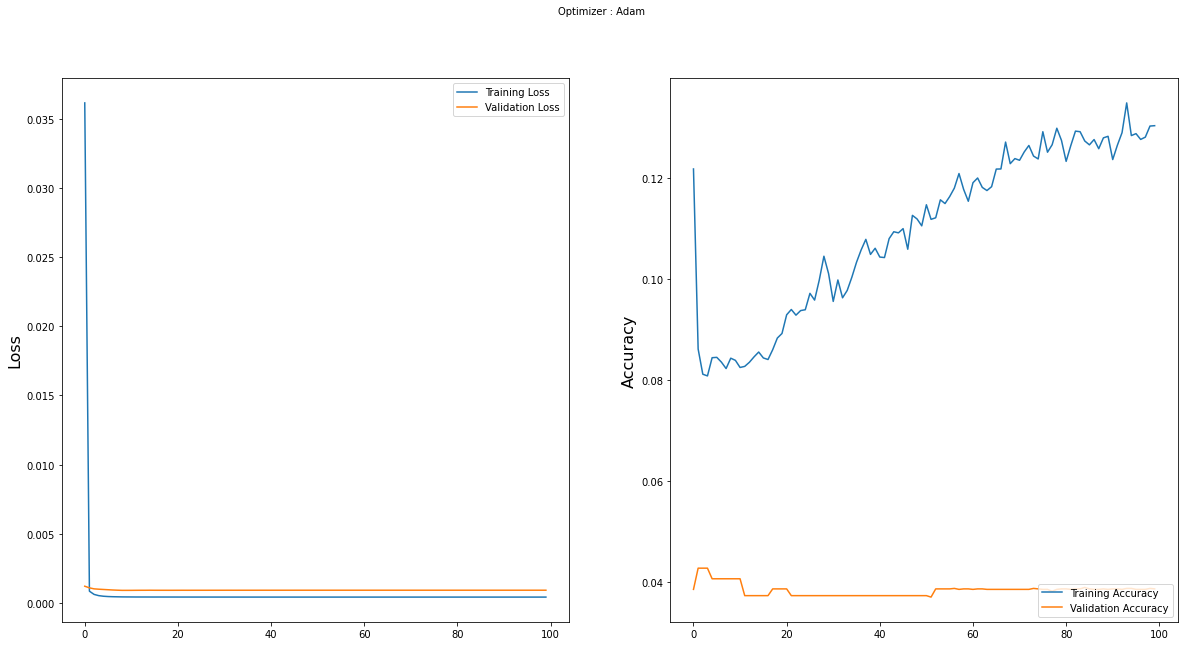

In [7]:
df2 = df.loc['2020-02-15 00:00:00' : '2020-04-07 00:00:00']

subset = df2[['feed_flow', 'feed_concentration', 'feed_temperature', 'stage_1_feed_pressure','A']]

subset['A'] = subset['A'].fillna(subset['A'].mean())

subset.reset_index(drop=True)


np.random.seed(1)

df_stg = subset[['A']]
    
#Normalize the 'stage_1_feed_pressure' feature using Minmax Normalization
minmax_scale = MinMaxScaler().fit(df_stg[['A']])
df_stg['minmax_A'] = minmax_scale.transform(df_stg[['A']])
    
#Dataframe column into series of values
entire_dataset = df_stg['minmax_A'].values

print("**********************************")
#Previous 15mins (look_back) timesteps used to predict next 15mins. 
look_back = 15
pred_length = 15
dataset_len = len(entire_dataset)

#split the dataset into train & text in the ratio of 70:30
train_size = int(dataset_len * 0.70)
test_size = dataset_len - train_size


#Change the shape of the series from 1D array to 2D array
entire_dataset = entire_dataset.reshape(-1,1)

train, test = entire_dataset[0:train_size,:], entire_dataset[train_size:dataset_len,:]

#Covert into supervised problem. Input -> Output using Sequence of previous 
#time steps to generate future time steps
# Eg. T1, T2, T3 -> T4
#     T2, T3, T4 -> T5
def create_subSeq(dataseries, look_back, pred_length):
    ip, op = [], []
    for i in range(len(dataseries)):
        ip_index = i + look_back
        op_index = ip_index + pred_length
        if(op_index > len(dataseries)):
            break
        seq_x, seq_y = dataseries[i:ip_index], dataseries[ip_index:op_index]
        ip.append(seq_x)
        op.append(seq_y)
    return np.array(ip), np.array(op)


X_train, Y_train = create_subSeq(train, look_back, pred_length)
X_test, Y_test = create_subSeq(test, look_back, pred_length)

Y_test_list = Y_test

# reshape from [samples, timesteps] into [samples, timesteps, features]-> 3D array as input to LSTM
# sample = number of samples, timesteps= look_back, features = 1 
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

#reshape Y's as [samples, timesteps]-> samples, pred_length
Y_train = Y_train.reshape((Y_train.shape[0], Y_train.shape[1]))
Y_test = Y_test.reshape((Y_test.shape[0], Y_test.shape[1]))

#Build model
model = Sequential()
model.add(LSTM(256,activation ='tanh', input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(128,activation ='tanh', return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(64,activation ='tanh', return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(32,activation ='tanh', return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(16))
model.add(Dense(pred_length))

adam = keras.optimizers.Adam(lr=0.001)

model.compile(loss='mean_squared_error',optimizer=adam,metrics=['accuracy'])
model.summary()

history = model.fit(X_train, Y_train, epochs=100, batch_size=128, validation_split=0.2,verbose=2,shuffle=False)



plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


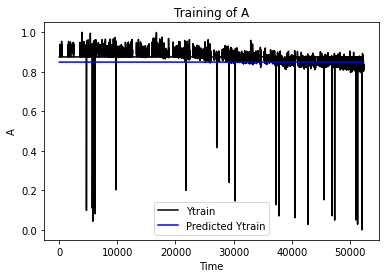

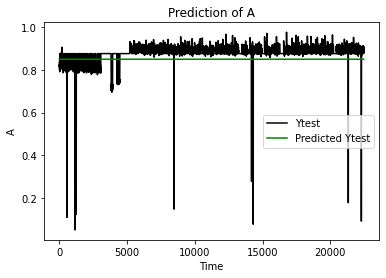

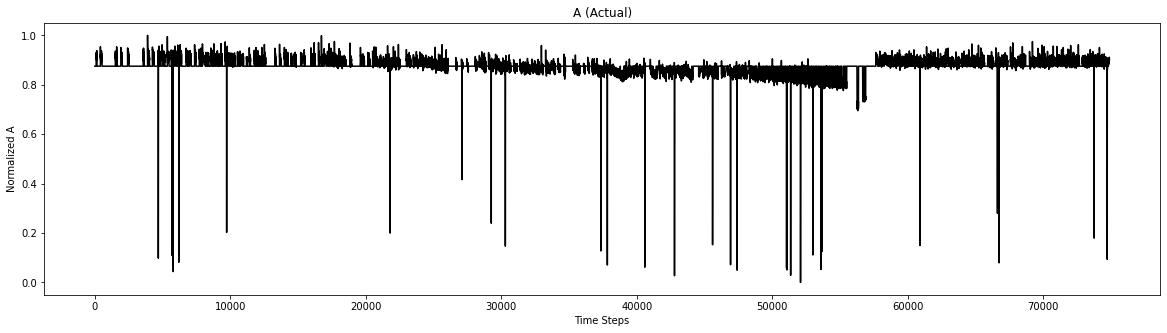

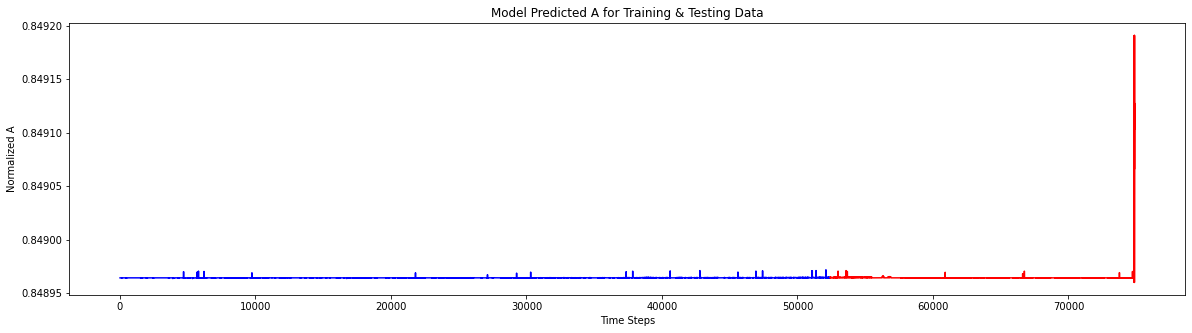

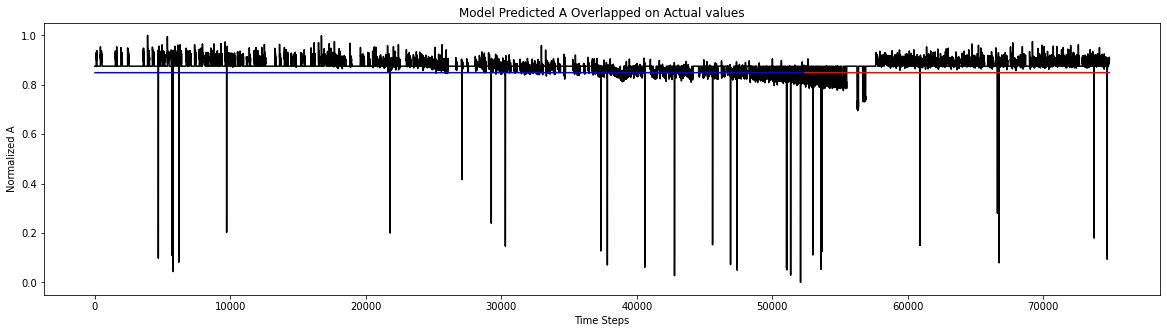

In [8]:

#Prediction of Y_train and Y_test
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

ytrainlist = []
ytrainpredlist = []
ytestpredlist = []
ytestlist = []
l=0

#Plotting the actual time-series, trained, tested values for which we are accordingly storing the values in a list based on the number of look_back, future_steps that were used to created sequential series

for i in range(testPredict.shape[0]-1):
  ytestpredlist.append(testPredict[i][0])
  ytestlist.append(Y_test[i][0])
  l=i

for i in range(trainPredict.shape[0]-1):
  ytrainlist.append(Y_train[i][0])
  ytrainpredlist.append(trainPredict[i][0])

last_row_index = testPredict.shape[0]-1

for i in range(testPredict.shape[1]):
  ytestpredlist.append(testPredict[last_row_index][i])
  ytestlist.append(Y_test[last_row_index][i])

for i in range(trainPredict.shape[1]):
  ytestpredlist.append(trainPredict[last_row_index][i])
  ytestlist.append(Y_train[last_row_index][i])

Y_test = np.array(ytestlist)
Y_test = Y_test.reshape((-1,1))


testPred = np.array(ytestpredlist)
testPred = testPred.reshape((-1,1))

Y_train = np.array(ytrainlist)
Y_train = Y_train.reshape((-1,1))

trainPred = np.array(ytrainpredlist)
trainPred = trainPred.reshape((-1,1))


#Compare actual Ytrain, Ytest with predicted Ytrain & Ytest
# %matplotlib inline

plt.plot(Y_train, color = 'black', label = 'Ytrain')
plt.plot(trainPred, color = 'blue', label = 'Predicted Ytrain')
plt.title('Training of A')
plt.xlabel('Time')
plt.ylabel('A')
plt.legend()
plt.show(block = False)


plt.plot(Y_test, color = 'black', label = 'Ytest')
plt.plot(testPred, color = 'green', label = 'Predicted Ytest')
plt.title('Prediction of A')
plt.xlabel('Time')
plt.ylabel('A')
plt.legend()
plt.show(block = False)

#Plot the Forecasted values overlapped on top of Actual values of 'A' data(normalized)
trainPredictPlot = np.empty_like(entire_dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPred)+look_back, :] = trainPred

testPredictPlot = np.empty_like(entire_dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPred)+(look_back)*2:len(entire_dataset), :] = testPred

plt.figure(figsize=(20,5))
plt.plot(entire_dataset, color = 'black',label = 'A (Actual)')
plt.title('A (Actual)')
plt.ylabel('Normalized A')
plt.xlabel('Time Steps')
plt.show(block = False)

plt.figure(figsize=(20,5))
plt.plot(trainPredictPlot, color = 'blue', label = 'A (Trained)')
plt.plot(testPredictPlot, color = 'red', label = 'A (Tested)')
plt.title('Model Predicted A for Training & Testing Data')
plt.ylabel('Normalized A')
plt.xlabel('Time Steps')
plt.show(block = False)

plt.figure(figsize=(20,5))
plt.plot(entire_dataset, color = 'black')
plt.plot(trainPredictPlot, color = 'blue')
plt.plot(testPredictPlot, color = 'red', label = 'A (Predicted)')
plt.title('Model Predicted A Overlapped on Actual values')
plt.ylabel('Normalized A')
plt.xlabel('Time Steps')
plt.show(block = False)
  


In [ ]:
#Trying to impute missing values with '0' and build the lstm model for 'A'

**********************************
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 15, 256)           264192    
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 256)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 15, 128)           197120    
_________________________________________________________________
dropout_5 (Dropout)          (None, 15, 128)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 15, 64)            49408     
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 64)            0         
_________________________________________________________________
lstm_8 (LSTM)      

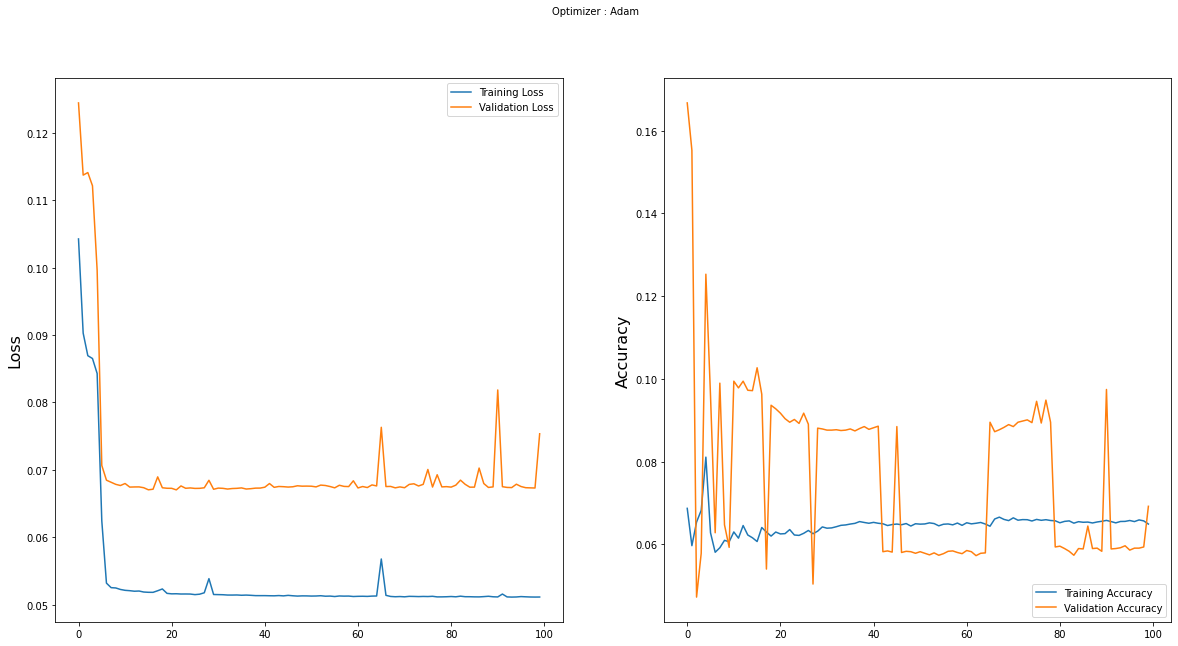

In [9]:
df2 = df.loc['2020-02-15 00:00:00' : '2020-04-07 00:00:00']

subset = df2[['feed_flow', 'feed_concentration', 'feed_temperature', 'stage_1_feed_pressure','A']]

subset['A'] = subset['A'].fillna(0)

subset.reset_index(drop=True)


np.random.seed(1)

df_stg = subset[['A']]
    
#Normalize the 'stage_1_feed_pressure' feature using Minmax Normalization
minmax_scale = MinMaxScaler().fit(df_stg[['A']])
df_stg['minmax_A'] = minmax_scale.transform(df_stg[['A']])
    
#Dataframe column into series of values
entire_dataset = df_stg['minmax_A'].values

print("**********************************")
#Previous 15mins (look_back) timesteps used to predict next 15mins. 
look_back = 15
pred_length = 15
dataset_len = len(entire_dataset)

#split the dataset into train & text in the ratio of 70:30
train_size = int(dataset_len * 0.70)
test_size = dataset_len - train_size


#Change the shape of the series from 1D array to 2D array
entire_dataset = entire_dataset.reshape(-1,1)

train, test = entire_dataset[0:train_size,:], entire_dataset[train_size:dataset_len,:]

#Covert into supervised problem. Input -> Output using Sequence of previous 
#time steps to generate future time steps
# Eg. T1, T2, T3 -> T4
#     T2, T3, T4 -> T5
def create_subSeq(dataseries, look_back, pred_length):
    ip, op = [], []
    for i in range(len(dataseries)):
        ip_index = i + look_back
        op_index = ip_index + pred_length
        if(op_index > len(dataseries)):
            break
        seq_x, seq_y = dataseries[i:ip_index], dataseries[ip_index:op_index]
        ip.append(seq_x)
        op.append(seq_y)
    return np.array(ip), np.array(op)


X_train, Y_train = create_subSeq(train, look_back, pred_length)
X_test, Y_test = create_subSeq(test, look_back, pred_length)

Y_test_list = Y_test

# reshape from [samples, timesteps] into [samples, timesteps, features]-> 3D array as input to LSTM
# sample = number of samples, timesteps= look_back, features = 1 
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

#reshape Y's as [samples, timesteps]-> samples, pred_length
Y_train = Y_train.reshape((Y_train.shape[0], Y_train.shape[1]))
Y_test = Y_test.reshape((Y_test.shape[0], Y_test.shape[1]))

#Build model
model = Sequential()
model.add(LSTM(256,activation ='tanh', input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(128,activation ='tanh', return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(64,activation ='tanh', return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(32,activation ='tanh', return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(16))
model.add(Dense(pred_length))

adam = keras.optimizers.Adam(lr=0.001)

model.compile(loss='mean_squared_error',optimizer=adam,metrics=['accuracy'])
model.summary()

history = model.fit(X_train, Y_train, epochs=100, batch_size=128, validation_split=0.2,verbose=2,shuffle=False)



plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


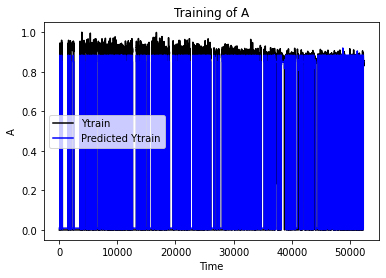

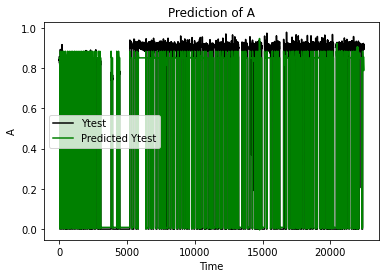

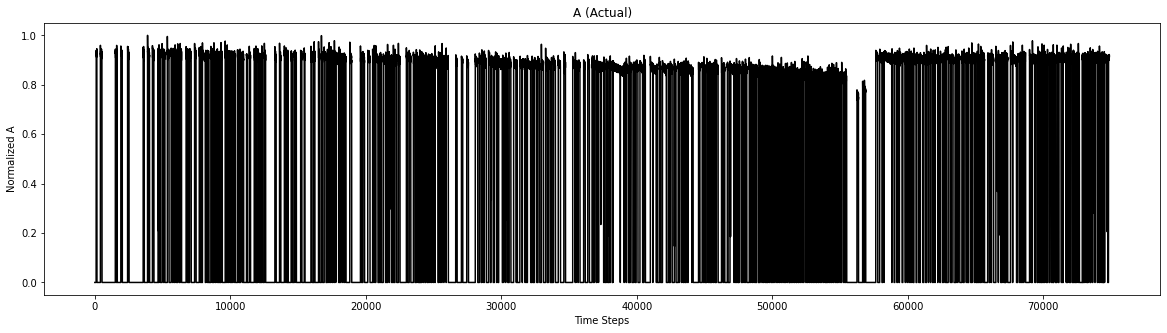

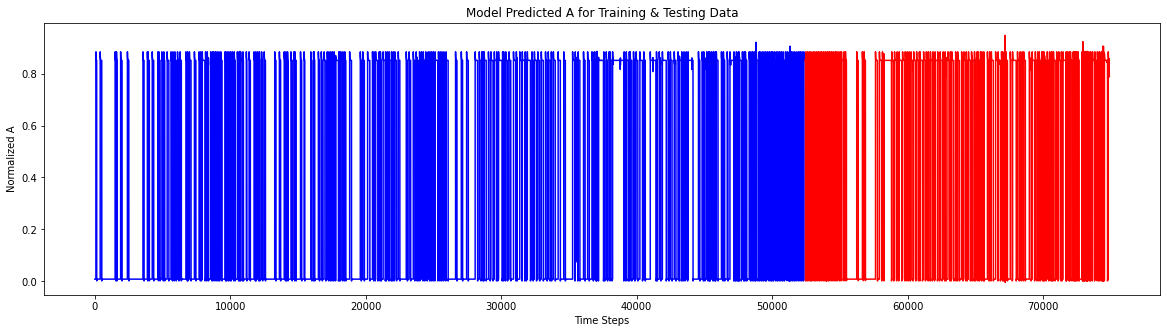

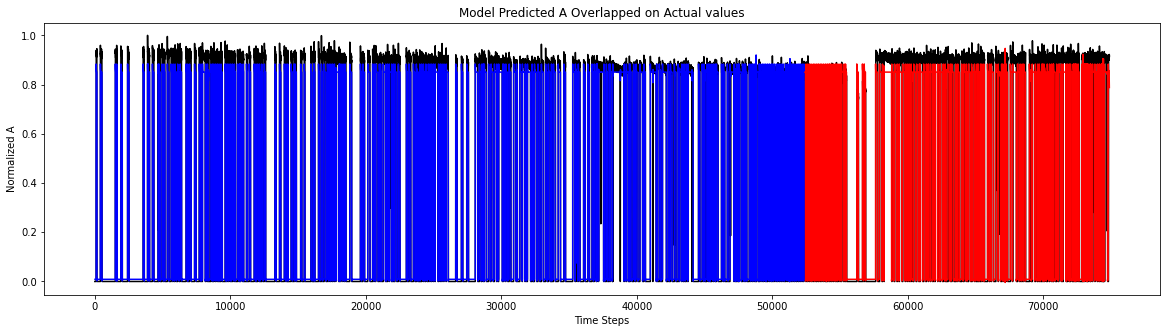

In [10]:

#Prediction of Y_train and Y_test
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

ytrainlist = []
ytrainpredlist = []
ytestpredlist = []
ytestlist = []
l=0

#Plotting the actual time-series, trained, tested values for which we are accordingly storing the values in a list based on the number of look_back, future_steps that were used to created sequential series

for i in range(testPredict.shape[0]-1):
  ytestpredlist.append(testPredict[i][0])
  ytestlist.append(Y_test[i][0])
  l=i

for i in range(trainPredict.shape[0]-1):
  ytrainlist.append(Y_train[i][0])
  ytrainpredlist.append(trainPredict[i][0])


last_row_index = testPredict.shape[0]-1

for i in range(testPredict.shape[1]):
  ytestpredlist.append(testPredict[last_row_index][i])
  ytestlist.append(Y_test[last_row_index][i])

for i in range(trainPredict.shape[1]):
  ytestpredlist.append(trainPredict[last_row_index][i])
  ytestlist.append(Y_train[last_row_index][i])

Y_test = np.array(ytestlist)
Y_test = Y_test.reshape((-1,1))


testPred = np.array(ytestpredlist)
testPred = testPred.reshape((-1,1))

Y_train = np.array(ytrainlist)
Y_train = Y_train.reshape((-1,1))

trainPred = np.array(ytrainpredlist)
trainPred = trainPred.reshape((-1,1))



#Compare actual Ytrain, Ytest with predicted Ytrain & Ytest
# %matplotlib inline

plt.plot(Y_train, color = 'black', label = 'Ytrain')
plt.plot(trainPred, color = 'blue', label = 'Predicted Ytrain')
plt.title('Training of A')
plt.xlabel('Time')
plt.ylabel('A')
plt.legend()
plt.show(block = False)


plt.plot(Y_test, color = 'black', label = 'Ytest')
plt.plot(testPred, color = 'green', label = 'Predicted Ytest')
plt.title('Prediction of A')
plt.xlabel('Time')
plt.ylabel('A')
plt.legend()
plt.show(block = False)

#Plot the Forecasted values overlapped on top of Actual values of 'A' data(normalized)
trainPredictPlot = np.empty_like(entire_dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPred)+look_back, :] = trainPred

testPredictPlot = np.empty_like(entire_dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPred)+(look_back)*2:len(entire_dataset), :] = testPred

plt.figure(figsize=(20,5))
plt.plot(entire_dataset, color = 'black',label = 'A (Actual)')
plt.title('A (Actual)')
plt.ylabel('Normalized A')
plt.xlabel('Time Steps')
plt.show(block = False)

plt.figure(figsize=(20,5))
plt.plot(trainPredictPlot, color = 'blue', label = 'A (Trained)')
plt.plot(testPredictPlot, color = 'red', label = 'A (Tested)')
plt.title('Model Predicted A for Training & Testing Data')
plt.ylabel('Normalized A')
plt.xlabel('Time Steps')
plt.show(block = False)

plt.figure(figsize=(20,5))
plt.plot(entire_dataset, color = 'black')
plt.plot(trainPredictPlot, color = 'blue')
plt.plot(testPredictPlot, color = 'red', label = 'A (Predicted)')
plt.title('Model Predicted A Overlapped on Actual values')
plt.ylabel('Normalized A')
plt.xlabel('Time Steps')
plt.show(block = False)
  



In [ ]:
#Based on the above the LSTM model for Stage_1_feed_pressure' is kind of forecasting better when the missing values are imputed with mean values